In [110]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading

In [111]:
file_path = r"D:\Git Repositories\AuctionScout-AI-powered-player-recommendations-for-IPL-auctions\dataset\bowlers_df.csv"
df = pd.read_csv(file_path)

In [112]:
df.columns

Index(['Player_Name', 'Deliveries_bowled', 'runs_conceded', 'wickets_taken',
       'overs', 'bowling_average', 'bowling_strike_rate', 'economy',
       'Recommendation'],
      dtype='object')

In [113]:
df['Recommendation'] = df['Recommendation'].replace({"BUY" : 1, "MAYBE" : 2, "DON'T BUY" : 3, np.nan : -1})

C:\Users\edwin victor\AppData\Local\Temp\ipykernel_5320\656150355.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Recommendation'] = df['Recommendation'].replace({"BUY" : 1, "MAYBE" : 2, "DON'T BUY" : 3, np.nan : -1})


In [114]:
df['Recommendation'] = df['Recommendation'].astype(int)

In [115]:
labeled_data = df[df['Recommendation'] != -1]
unlabeled_data = df[df['Recommendation'] == -1]

In [116]:
x_labeled = labeled_data[['Deliveries_bowled', 'runs_conceded', 'wickets_taken',
       'overs', 'bowling_average', 'bowling_strike_rate', 'economy',
               ]]


In [117]:
x_unlabeled = unlabeled_data.drop(columns=["Recommendation"])

In [118]:
y_labeled = labeled_data['Recommendation']

In [119]:
corr_matrix  = x_labeled.corr()

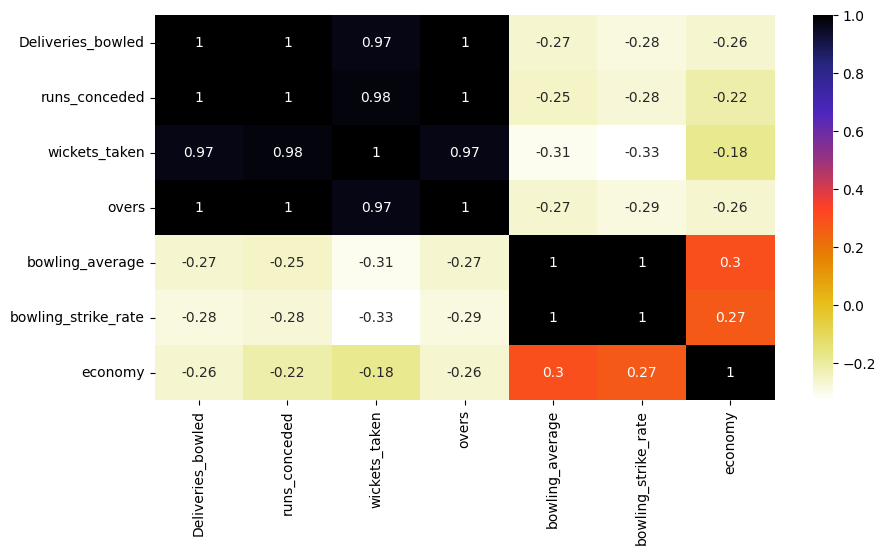

In [120]:
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [121]:
def correlation(dataset, Threshold):
    corr_matrix = dataset.corr()
    column_names = set()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > Threshold:
                col_name = corr_matrix.columns[i]
                column_names.add(col_name)
    return column_names

In [122]:
corr_features = correlation(x_labeled, 0.8)
corr_features

{'bowling_strike_rate', 'overs', 'runs_conceded', 'wickets_taken'}

In [123]:
x_labeled_dropped_column = x_labeled.drop(columns=['overs', 'runs_conceded', 'Deliveries_bowled'])

In [124]:
x_labeled_dropped_column

,wickets_taken,bowling_average,bowling_strike_rate,economy
0,63,24.86,19.81,7.53
1,36,31.06,26.69,6.99
2,7,40.43,26.29,9.43
3,0,48.44,39.12,9.00
4,8,54.38,42.75,7.63
5,0,48.44,39.12,10.00
6,19,21.05,18.47,6.90
7,1,27.00,24.00,6.75
8,5,46.00,35.00,7.93
9,89,21.56,15.85,8.17


In [125]:
unlabeled_data_dropped_columns = unlabeled_data.drop(columns=["Player_Name","Recommendation",'overs', 'runs_conceded', 'Deliveries_bowled'])
unlabeled_data_dropped_columns

,wickets_taken,bowling_average,bowling_strike_rate,economy
20,19,24.47,17.53,8.45
21,12,22.92,18.92,7.43
22,0,48.44,39.12,10.50
23,3,20.67,16.00,7.75
24,1,36.00,24.00,9.00
...,...,...,...,...
192,0,48.44,39.12,10.20
193,60,23.05,16.62,8.33
194,13,20.62,12.23,10.31
195,18,34.44,27.33,7.56


In [126]:
scaler = RobustScaler()
X_labeled_scaled = scaler.fit_transform(x_labeled_dropped_column)
X_unlabeled_scaled = scaler.transform(unlabeled_data_dropped_columns)

In [127]:
X_all = np.vstack((X_labeled_scaled, X_unlabeled_scaled))

In [128]:
y_all = np.concatenate((y_labeled, np.full(len(x_unlabeled), -1)))

In [129]:
model = LabelSpreading(kernel="knn", n_neighbors=5)
model.fit(X_all, y_all)

LabelSpreading(kernel='knn', n_neighbors=5)

In [130]:
predicted_labels = model.predict(X_unlabeled_scaled)


In [131]:
df

,Player_Name,Deliveries_bowled,runs_conceded,wickets_taken,overs,bowling_average,bowling_strike_rate,economy,Recommendation
0,A Zampa,1248,1566,63,208,24.86,19.81,7.53,1
1,AC Agar,961,1118,36,160,31.06,26.69,6.99,2
2,AD Russell,184,283,7,30,40.43,26.29,9.43,2
3,ADS Fletcher,6,9,0,1,48.44,39.12,9.00,3
4,AF Milne,342,435,8,57,54.38,42.75,7.63,3
...,...,...,...,...,...,...,...,...,...
192,XA Crone,30,51,0,5,48.44,39.12,10.20,-1
193,XC Bartlett,997,1383,60,166,23.05,16.62,8.33,-1
194,Z Evans,159,268,13,26,20.62,12.23,10.31,-1
195,Zahir Khan,492,620,18,82,34.44,27.33,7.56,-1


In [132]:
df.loc[df["Recommendation"] == -1, "Recommendation"] = predicted_labels
df["Recommendation"] = df["Recommendation"].replace({1: "BUY", 2: "MAYBE", 3: "DON'T BUY"})

In [133]:
df

,Player_Name,Deliveries_bowled,runs_conceded,wickets_taken,overs,bowling_average,bowling_strike_rate,economy,Recommendation
0,A Zampa,1248,1566,63,208,24.86,19.81,7.53,BUY
1,AC Agar,961,1118,36,160,31.06,26.69,6.99,MAYBE
2,AD Russell,184,283,7,30,40.43,26.29,9.43,MAYBE
3,ADS Fletcher,6,9,0,1,48.44,39.12,9.00,DON'T BUY
4,AF Milne,342,435,8,57,54.38,42.75,7.63,DON'T BUY
...,...,...,...,...,...,...,...,...,...
192,XA Crone,30,51,0,5,48.44,39.12,10.20,DON'T BUY
193,XC Bartlett,997,1383,60,166,23.05,16.62,8.33,BUY
194,Z Evans,159,268,13,26,20.62,12.23,10.31,MAYBE
195,Zahir Khan,492,620,18,82,34.44,27.33,7.56,MAYBE


In [135]:
fully_labeled_data = r"D:\Git Repositories\AuctionScout-AI-powered-player-recommendations-for-IPL-auctions\dataset\bowlers_df_labeled.csv"
df.to_csv(fully_labeled_data, index=False)